In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("dataset_cybersecurity_michelle.csv")
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,1,0,0,1,0,0,0,0,0,0,...,2,2,5,292,0,-1,0,0,0,1
1,2,5,4,2,0,0,0,0,0,0,...,2,4,2,52,0,1,0,0,0,1
2,2,0,0,0,0,0,0,0,0,0,...,2,2,0,298,1,1,0,0,0,0
3,1,1,0,2,0,0,0,0,0,0,...,1,2,5,1792,0,0,0,0,0,1
4,2,1,0,0,0,0,0,0,0,0,...,1,2,1,299,1,1,0,0,0,0


In [ ]:
df.isna().sum().sum() # no null values in the dataset

0

In [ ]:
df['phishing'].value_counts() # roughly balanced classes so no need for weighing/sampling techniques

phishing
0    77546
1    52152
Name: count, dtype: int64

In [ ]:
df.describe()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
count,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,...,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000,129698.000000
mean,2.220612,0.370044,0.132392,1.489892,0.010956,0.240459,0.025683,0.163750,0.003547,0.001234,...,1.130788,2.790490,1.710851,5806.972528,0.505382,0.332341,0.001365,0.002051,0.006369,0.402103
std,1.314717,1.199731,0.706240,1.963822,0.123975,1.027070,0.292883,0.991589,0.098266,0.081421,...,0.903889,1.339672,1.714852,10286.320400,0.499973,0.793889,0.052740,0.058474,0.079550,0.490324
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,291.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,1796.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.000000,10791.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,24.000000,35.000000,21.000000,44.000000,9.000000,23.000000,43.000000,26.000000,10.000000,9.000000,...,24.000000,20.000000,20.000000,604800.000000,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# some observations/intution about data
#trimming outliers, quartile replacements/winsorization could be helpful for some features
# quantity variables will likely be mutlicollinear with URL length

In [ ]:
#features with only one value will have no impact on our model (no variance)
nonvaried_data = [col for col in df.columns if df[col].nunique()==1]
nonvaried_data

['qty_slash_domain',
 'qty_questionmark_domain',
 'qty_equal_domain',
 'qty_and_domain',
 'qty_exclamation_domain',
 'qty_space_domain',
 'qty_tilde_domain',
 'qty_comma_domain',
 'qty_plus_domain',
 'qty_asterisk_domain',
 'qty_hashtag_domain',
 'qty_dollar_domain',
 'qty_percent_domain']

In [ ]:
#remove categorical data with too many unique values -- not suited for one hot encoding
overvaried_data = [col for col in df.columns if df[col].nunique()>100]
overvaried_data

['length_url',
 'directory_length',
 'file_length',
 'params_length',
 'time_response',
 'asn_ip',
 'time_domain_activation',
 'time_domain_expiration',
 'ttl_hostname']

In [ ]:
# one hot encoding of these categorical columns would yield way too many additional columns
columns_to_drop = nonvaried_data + ["asn_ip","ttl_hostname"]
df = df.drop(columns = columns_to_drop)

In [ ]:
df

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,time_domain_expiration,qty_ip_resolved,qty_nameservers,qty_mx_servers,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,1,0,0,1,0,0,0,0,0,0,...,551,2,2,5,0,-1,0,0,0,1
1,2,5,4,2,0,0,0,0,0,0,...,-1,2,4,2,0,1,0,0,0,1
2,2,0,0,0,0,0,0,0,0,0,...,123,2,2,0,1,1,0,0,0,0
3,1,1,0,2,0,0,0,0,0,0,...,-1,1,2,5,0,0,0,0,0,1
4,2,1,0,0,0,0,0,0,0,0,...,1631,1,2,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129693,3,1,0,0,0,0,0,0,0,0,...,334,1,3,1,0,0,0,0,0,0
129694,2,0,0,0,0,0,0,0,0,0,...,431,1,2,2,0,2,0,0,0,0
129695,2,1,0,5,0,0,0,0,0,0,...,712,1,2,5,1,0,0,0,0,1
129696,2,0,0,1,0,0,0,0,0,0,...,-1,1,1,1,1,0,0,0,0,1


In [ ]:
# look at correlation coefficient between each X variable and Y
df.corrwith(df['phishing']).sort_values()

time_domain_activation       -0.432957
qty_dot_domain               -0.254577
time_domain_expiration       -0.165301
qty_nameservers              -0.084696
qty_mx_servers               -0.073325
                                ...   
qty_hashtag_directory         0.717482
qty_questionmark_directory    0.717482
qty_dollar_file               0.717482
qty_slash_directory           0.721240
phishing                      1.000000
Length: 97, dtype: float64

Confusion Matrix:
 [[70850  6696]
 [ 4761 47391]]
Accuracy: 0.9116640194914339
ROC-AUC: 0.9704588442459323


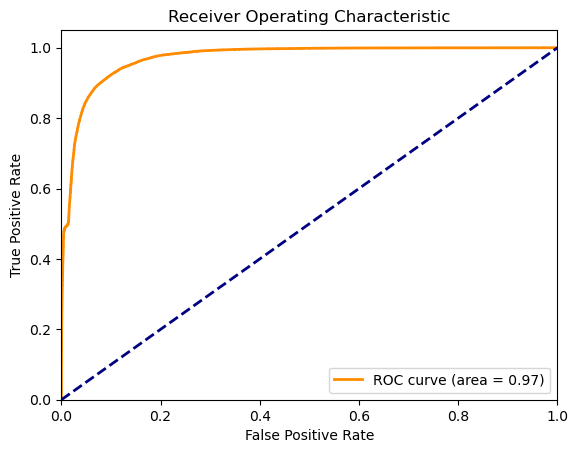

In [ ]:
#Baseline Logistic Regression using K-fold Cross Validation
X = df.drop('phishing', axis=1)
y = df['phishing']

logreg = LogisticRegression(solver='liblinear')
kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(logreg, X, y, cv=kf, method='predict')
y_prob = cross_val_predict(logreg, X, y, cv=kf, method='predict_proba')[:, 1]

conf_matrix = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y, y_prob)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)

fpr, tpr, _ = roc_curve(y, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Sorted by Importance:
                    Feature  Average Coefficient  Abs Average Coefficient
80           params_length             2.539640                 2.539640
6               qty_at_url             2.262621                 2.262621
82              qty_params            -1.369376                 1.369376
86  time_domain_activation            -1.320674                 1.320674
44        directory_length             1.232469                 1.232469
..                     ...                  ...                      ...
58       qty_asterisk_file            -0.009476                 0.009476
59        qty_hashtag_file             0.007328                 0.007328
40  qty_asterisk_directory             0.004541                 0.004541
57           qty_plus_file             0.003010                 0.003010
22           qty_at_domain             0.000000                 0.000000

[96 rows x 3 columns]

Accuracy: 0.9196749371617141
Confusion Matrix:
 [[71745  5801]
 [ 4617 47535]

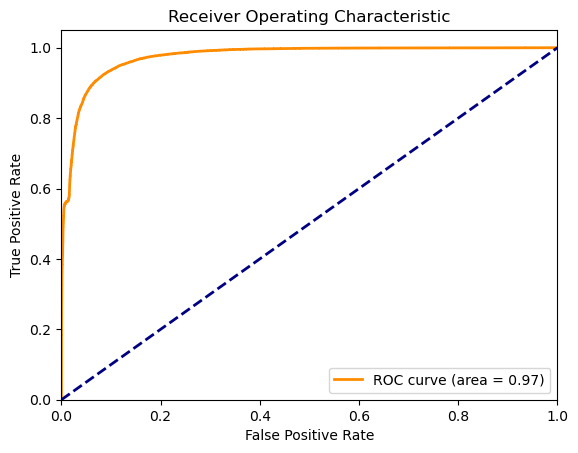

In [ ]:
# Logistic Regression Model with standard scaled X data and L1 Regularization w/ k-Fold Cross Validation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)


log_reg = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
coefficients_list = []
y_pred = cross_val_predict(log_reg, X_scaled, y, cv=kf)
y_prob = cross_val_predict(log_reg, X_scaled, y, cv=kf, method='predict_proba')[:, 1]

accuracy = accuracy_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
roc_auc = roc_auc_score(y, y_prob)

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    log_reg.fit(X_train, y_train)
    coefficients_list.append(log_reg.coef_[0])

avg_coefficients = np.mean(coefficients_list, axis=0)

coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Average Coefficient': avg_coefficients
})
coefficients_df['Abs Average Coefficient'] = coefficients_df['Average Coefficient'].abs()
sorted_coefficients = coefficients_df.sort_values(by='Abs Average Coefficient', ascending=False)

print("Sorted by Importance:\n", sorted_coefficients)
print("\nAccuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("ROC-AUC:", roc_auc)

fpr, tpr, _ = roc_curve(y, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Top 10 most important features
coefficients_df.sort_values(by = "Abs Average Coefficient", ascending = False).head(10)

,Feature,Average Coefficient,Abs Average Coefficient
80,params_length,2.539640,2.539640
6,qty_at_url,2.262621,2.262621
82,qty_params,-1.369376,1.369376
86,time_domain_activation,-1.320674,1.320674
44,directory_length,1.232469,1.232469
18,length_url,1.141182,1.141182
32,qty_equal_directory,1.090708,1.090708
13,qty_asterisk_url,1.048840,1.048840
70,qty_and_params,0.952730,0.952730
27,qty_dot_directory,0.846005,0.846005


Confusion Matrix:
 [[76636   910]
 [  685 51467]]
Accuracy: 0.9877022004965381
ROC-AUC: 0.9981545748803988


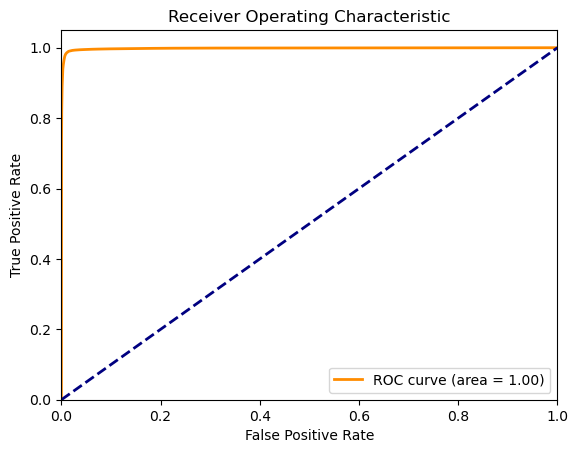

In [ ]:
# Baseline Random Forest Classifier using K-fold Cross Validation

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(random_forest, X, y, cv=kf)
y_prob = cross_val_predict(random_forest, X, y, cv=kf, method='predict_proba')[:, 1]

conf_matrix = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
roc_auc = roc_auc_score(y, y_prob)

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)

fpr, tpr, _ = roc_curve(y, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

C:\Users\aptek\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Selected features based on importances: Index(['qty_dot_url', 'qty_slash_url', 'length_url', 'qty_dot_domain',
       'qty_vowels_domain', 'domain_length', 'qty_dot_directory',
       'qty_hyphen_directory', 'qty_underline_directory',
       'qty_slash_directory', 'qty_equal_directory', 'qty_and_directory',
       'qty_tilde_directory', 'qty_plus_directory', 'qty_asterisk_directory',
       'qty_hashtag_directory', 'qty_percent_directory', 'directory_length',
       'qty_dot_file', 'qty_hyphen_file', 'qty_underline_file',
       'qty_slash_file', 'qty_at_file', 'qty_tilde_file', 'qty_plus_file',
       'qty_asterisk_file', 'qty_dollar_file', 'qty_percent_file',
       'file_length', 'time_response', 'time_domain_activation',
       'time_domain_expiration', 'qty_ip_resolved', 'qty_nameservers',
       'qty_mx_servers', 'qty_redirects'],
      dtype='object')
Cross-Validated Accuracy: 0.9866998681415027
Cross-Validated ROC-AUC: 0.9979201015015751


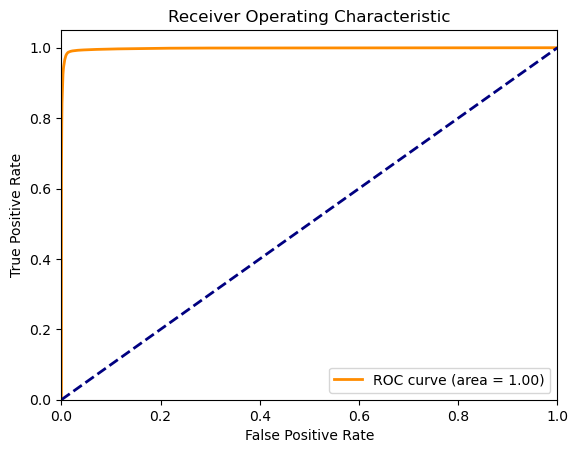

Confusion Matrix:
 [[76563   983]
 [  742 51410]]


In [ ]:
# Random Forest Classifier using features with importance above mean (and K-Fold Cross Validation)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
model = SelectFromModel(rf, prefit=True)
X_new = model.transform(X)
selected_features = X.columns[model.get_support()]

print("Selected features based on importances:", selected_features)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_new = RandomForestClassifier(n_estimators=100, random_state=42)
scores_accuracy = cross_val_score(rf_new, X_new, y, cv=kf, scoring='accuracy')
scores_roc_auc = cross_val_score(rf_new, X_new, y, cv=kf, scoring='roc_auc')

print("Cross-Validated Accuracy:", np.mean(scores_accuracy))
print("Cross-Validated ROC-AUC:", np.mean(scores_roc_auc))
y_pred = cross_val_predict(rf_new, X_new, y, cv=kf)
y_prob = cross_val_predict(rf_new, X_new, y, cv=kf, method='predict_proba')[:, 1]

conf_matrix = confusion_matrix(y, y_pred)
roc_auc = roc_auc_score(y, y_prob)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", conf_matrix)